In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sn
from gensim.models import KeyedVectors
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, Dropout

from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
with open("clean_az_brown2.txt", 'r', encoding='utf-8') as f:
    s2 = f.read().splitlines()
s3 = [re.sub('\n', '', sentence) for sentence in s2]    
tagged_sentences = [sentence.split(" ") for sentence in s3]
corpus = [[tuple(word.split("/")) for word in sentence] for sentence in tagged_sentences]

In [3]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in corpus:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [4]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Həkan-həkan', 'içində', ',', 'qoz', 'girdəkan', 'içində', ',', 'dəvə', 'dəlləklik', 'elər', ',', 'köhnə', 'hamam', 'içində', '.'] 

sample Y:  ['Isim', 'Zərf', ',', 'Isim', 'Isim', 'Zərf', ',', 'Isim', 'Isim', 'Fel', ',', 'Sifət', 'Isim', 'Zərf', 'Durğu_işarəsi'] 



In [5]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [6]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 1806
Vocabulary size: 6644
Total number of tags: 15


In [7]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 15
Length of first output sequence : 15


In [8]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [9]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [10]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Həkan-həkan', 'içində', ',', 'qoz', 'girdəkan', 'içində', ',', 'dəvə', 'dəlləklik', 'elər', ',', 'köhnə', 'hamam', 'içində', '.'] 

Y:  ['Isim', 'Zərf', ',', 'Isim', 'Isim', 'Zərf', ',', 'Isim', 'Isim', 'Fel', ',', 'Sifət', 'Isim', 'Zərf', 'Durğu_işarəsi'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [2106, 225, 2, 765, 1195, 225, 2, 2107, 2108, 2109, 2, 351, 2110, 225, 1] 

Y:  [1, 7, 6, 1, 1, 7, 6, 1, 1, 2, 6, 5, 1, 7, 3] 



In [11]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [12]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 88


c:\users\asus tuf\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


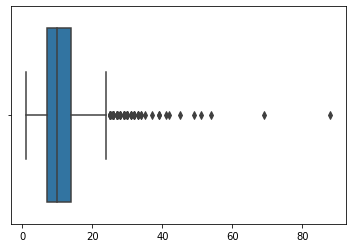

In [13]:
sn.boxplot(lengths)
plt.show()

In [14]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 40  # sequences greater than 40 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")

In [15]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[2106  225    2  765 1195  225    2 2107 2108 2109    2  351 2110  225
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0] 



[1 7 6 1 1 7 6 1 1 2 6 5 1 7 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [16]:
#assign padded sequences to X and Y
X, Y = X_padded, Y_padded

# Word embeddings

Currently, each word and each tag is encoded as an integer. We'll use a more sophisticated technique to represent the input words (X) using what's known as word embeddings. However, to represent each tag in Y, we'll simply use one-hot encoding scheme since there are only 13 tags in the dataset and the LSTM will have no problems in learning its own representation of these tags. 
To use word embeddings, you can go for either of the following models:

* word2vec model: https://code.google.com/archive/p/word2vec/
* GloVe model : https://nlp.stanford.edu/projects/glove/
* fasttext : https://fasttext.cc/docs/en/crawl-vectors.html

We're using the fastText model because they have pre-trained model for Azerbaijani lanuage. Both of these are very efficient in representing words. You can try both and see which one works better.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

In [17]:
import fasttext

In [18]:
path = 'D:/PostgresData/cc.az.300.bin'
ft = fasttext.load_model(path)

In [19]:
ft.get_nearest_neighbors('daşı')

[(0.7162571549415588, 'daşıKür'),
 (0.705851137638092, 'daşını'),
 (0.6851230263710022, 'daşının'),
 (0.6766510605812073, 'daşını-daş'),
 (0.6592142581939697, 'daşı-'),
 (0.6435108184814453, 'daşın'),
 (0.6427285671234131, 'daşından'),
 (0.6406784653663635, 'məhək'),
 (0.6388031840324402, 'daşında'),
 (0.6243704557418823, 'daşıt')]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of its substrings. As long as the unknown word is made of known substrings, there is a representation of it!


In [20]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
tag2id = tag_tokenizer.word_index

# copy vectors from fasttext model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = ft.get_word_vector(word)
    except KeyError:
        pass

In [21]:
word2id

{'.': 1,
 ',': 2,
 'bir': 3,
 'və': 4,
 'bu': 5,
 'ki': 6,
 'də': 7,
 ':': 8,
 'mən': 9,
 'o': 10,
 'da': 11,
 'idi': 12,
 'sonra': 13,
 'ilə': 14,
 '-': 15,
 '?': 16,
 'kimi': 17,
 'onun': 18,
 'dedi': 19,
 'nə': 20,
 'üçün': 21,
 'çox': 22,
 'şah': 23,
 'oğlan': 24,
 'isə': 25,
 'mənim': 26,
 'qədər': 27,
 'elə': 28,
 'heç': 29,
 'mənə': 30,
 'var': 31,
 '!': 32,
 'belə': 33,
 'qara': 34,
 'hər': 35,
 'həsən': 36,
 'vəzir': 37,
 'onu': 38,
 'xan': 39,
 'öz': 40,
 'ona': 41,
 'allahverdi': 42,
 'olan': 43,
 'böyük': 44,
 'amma': 45,
 'sən': 46,
 'nino': 47,
 'məni': 48,
 'əmim': 49,
 'biz': 50,
 'qız': 51,
 'lakin': 52,
 'saat': 53,
 'ən': 54,
 'gün': 55,
 'az': 56,
 'dəfə': 57,
 'çünki': 58,
 'abbas': 59,
 'daha': 60,
 'olsun': 61,
 'bütün': 62,
 'yaxşı': 63,
 'tutub': 64,
 'sağ': 65,
 'bokassa': 66,
 'sənə': 67,
 'görə': 68,
 'başladı': 69,
 'olub': 70,
 'gördüm': 71,
 'hüseyn': 72,
 'deyə': 73,
 'gərək': 74,
 'yox': 75,
 'dedim': 76,
 'biri': 77,
 'cavab': 78,
 'i̇ndi': 79,
 'gözəl

In [22]:
tag2id

{'isim': 1,
 'fel': 2,
 'durğu_işarəsi': 3,
 'əvəzlik': 4,
 'sifət': 5,
 ',': 6,
 'zərf': 7,
 'bağlayıcı': 8,
 'say': 9,
 'ədat': 10,
 'qoşma': 11,
 'hissəcik': 12,
 '-': 13,
 'modal': 14,
 'nida': 15}

In [23]:
embedding_weights

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00102859,  0.00347523, -0.02413049, ...,  0.01146229,
        -0.02182749,  0.05498237],
       [ 0.01508238, -0.09417729, -0.00520617, ...,  0.05473669,
         0.02815216, -0.03679167],
       ...,
       [-0.03868638, -0.04036696,  0.01798723, ...,  0.01122547,
         0.00102954, -0.0217728 ],
       [ 0.0077829 , -0.00505276,  0.02708293, ..., -0.00563868,
        -0.00104441, -0.00371161],
       [-0.02288908, -0.05111634, -0.0320226 , ...,  0.07234171,
         0.01533616, -0.05874455]])

In [24]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (6645, 300)


In [25]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [26]:
Y

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [27]:
# print Y of the first output sequqnce
print(Y.shape)

(1806, 40, 16)


In [28]:
# split entire data into training and testing sets
TEST_SIZE = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=8)

In [29]:
# split training data into training and validation sets
VALID_SIZE = 0.25
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=8)

In [30]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (1083, 40)
Shape of output sequences: (1083, 40, 16)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (361, 40)
Shape of output sequences: (361, 40, 16)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (362, 40)
Shape of output sequences: (362, 40, 16)


Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

* Shape of X: (#samples, #timesteps, #features)

* Shape of Y: (#samples, #timesteps, #features)



Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

In [31]:
l=64
d=0.5
b=5
e=5

In [32]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Vanilla RNN

In [34]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(l, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [35]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc', f1_m])

In [36]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           1993500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 64)            23360     
                                                                 
 time_distributed (TimeDistr  (None, 40, 16)           1040      
 ibuted)                                                         
                                                                 
Total params: 2,017,900
Trainable params: 24,400
Non-trainable params: 1,993,500
_________________________________________________________________


In [37]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=5, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
217/217 [==============================] - 2s 5ms/step - loss: 0.7525 - acc: 0.7901 - f1_m: 0.7949 - val_loss: 0.5328 - val_acc: 0.8579 - val_f1_m: 0.8410
Epoch 2/5
217/217 [==============================] - 1s 3ms/step - loss: 0.4780 - acc: 0.8619 - f1_m: 0.8575 - val_loss: 0.4339 - val_acc: 0.8649 - val_f1_m: 0.8709
Epoch 3/5
217/217 [==============================] - 1s 3ms/step - loss: 0.4101 - acc: 0.8705 - f1_m: 0.8710 - val_loss: 0.3915 - val_acc: 0.8755 - val_f1_m: 0.8735
Epoch 4/5
217/217 [==============================] - 1s 3ms/step - loss: 0.3690 - acc: 0.8807 - f1_m: 0.8803 - val_loss: 0.3549 - val_acc: 0.8835 - val_f1_m: 0.8850
Epoch 5/5
217/217 [==============================] - 1s 3ms/step - loss: 0.3357 - acc: 0.8906 - f1_m: 0.8891 - val_loss: 0.3343 - val_acc: 0.8879 - val_f1_m: 0.8901


# 2. LSTM

In [38]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(l, return_sequences=True))
lstm_model.add(Dropout(d))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [39]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc', f1_m])

In [40]:
# check summary of the model
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 300)           1993500   
                                                                 
 lstm (LSTM)                 (None, 40, 64)            93440     
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 40, 16)           1040      
 tributed)                                                       
                                                                 
Total params: 2,087,980
Trainable params: 2,087,980
Non-trainable params: 0
_________________________________________________________________


In [41]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=5, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
217/217 [==============================] - 4s 15ms/step - loss: 0.7399 - acc: 0.8256 - f1_m: 0.7794 - val_loss: 0.4290 - val_acc: 0.8769 - val_f1_m: 0.8705
Epoch 2/5
217/217 [==============================] - 3s 15ms/step - loss: 0.3351 - acc: 0.9025 - f1_m: 0.9025 - val_loss: 0.2371 - val_acc: 0.9331 - val_f1_m: 0.9320
Epoch 3/5
217/217 [==============================] - 4s 18ms/step - loss: 0.1576 - acc: 0.9566 - f1_m: 0.9585 - val_loss: 0.1636 - val_acc: 0.9555 - val_f1_m: 0.9527
Epoch 4/5
217/217 [==============================] - 4s 18ms/step - loss: 0.0854 - acc: 0.9788 - f1_m: 0.9771 - val_loss: 0.1423 - val_acc: 0.9611 - val_f1_m: 0.9587
Epoch 5/5
217/217 [==============================] - 4s 18ms/step - loss: 0.0579 - acc: 0.9860 - f1_m: 0.9844 - val_loss: 0.1329 - val_acc: 0.9617 - val_f1_m: 0.9614


In [77]:
# # create architecture

# rnn_model = Sequential()

# # create embedding layer - usually the first layer in text problems
# rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
#                         output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
#                         input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
#                         trainable     =  True                     # True - update the embeddings while training
# ))
l=8
d=0.65
# # add an RNN layer which contains 64 RNN cells
# rnn_model.add(SimpleRNN(64, 
#               return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
# ))

# # add time distributed (output at each sequence) layer
# rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [78]:
# rnn_model.compile(loss      =  'categorical_crossentropy',
#                   optimizer =  'adam',
#                   metrics   =  ['acc'])

# 3. GRU

In [79]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(l, return_sequences=True))
gru_model.add(Dropout(d))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [80]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', f1_m])

In [81]:
# check summary of model
gru_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 40, 300)           1993500   
                                                                 
 gru_5 (GRU)                 (None, 40, 8)             7440      
                                                                 
 dropout_7 (Dropout)         (None, 40, 8)             0         
                                                                 
 time_distributed_8 (TimeDis  (None, 40, 16)           144       
 tributed)                                                       
                                                                 
Total params: 2,001,084
Trainable params: 2,001,084
Non-trainable params: 0
_________________________________________________________________


In [82]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=5, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
217/217 [==============================] - 5s 18ms/step - loss: 1.4290 - acc: 0.6612 - f1_m: 0.4793 - val_loss: 0.6861 - val_acc: 0.8332 - val_f1_m: 0.8421
Epoch 2/5
217/217 [==============================] - 4s 16ms/step - loss: 0.8224 - acc: 0.8111 - f1_m: 0.7508 - val_loss: 0.4760 - val_acc: 0.9098 - val_f1_m: 0.8421
Epoch 3/5
217/217 [==============================] - 4s 17ms/step - loss: 0.6463 - acc: 0.8265 - f1_m: 0.7968 - val_loss: 0.3713 - val_acc: 0.9332 - val_f1_m: 0.8910
Epoch 4/5
217/217 [==============================] - 4s 18ms/step - loss: 0.5465 - acc: 0.8412 - f1_m: 0.8366 - val_loss: 0.3114 - val_acc: 0.9400 - val_f1_m: 0.9119
Epoch 5/5
217/217 [==============================] - 4s 18ms/step - loss: 0.4879 - acc: 0.8523 - f1_m: 0.8541 - val_loss: 0.2704 - val_acc: 0.9474 - val_f1_m: 0.9241


# 5. Model evaluation


In [83]:
rnn_64_loss, rnn_64_accuracy, rnn_64_f1_score = rnn_model.evaluate(X_test, Y_test, verbose = 1)

12/12 [==============================] - 0s 3ms/step - loss: 0.3390 - acc: 0.8854 - f1_m: 0.8889


In [84]:
lstm_64_loss, lstm_64_accuracy, lstm_64_f1_score = lstm_model.evaluate(X_test, Y_test, verbose = 1)

12/12 [==============================] - 0s 7ms/step - loss: 0.1310 - acc: 0.9627 - f1_m: 0.9604


In [85]:
gru_64_loss, gru_64_accuracy, gru_64_f1_score = gru_model.evaluate(X_test, Y_test, verbose = 1)

12/12 [==============================] - 0s 3ms/step - loss: 0.2739 - acc: 0.9490 - f1_m: 0.9220


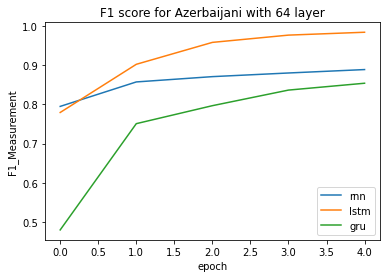

In [93]:
plt.plot(rnn_training.history['f1_m'])
plt.plot(lstm_training.history['f1_m'])
plt.plot(gru_training.history['f1_m'])
plt.title('F1 score for Azerbaijani with 64 layer')
plt.ylabel('F1_Measurement')
plt.xlabel('epoch')
plt.legend(['rnn', 'lstm', 'gru'], loc="lower right")
plt.show()

In [90]:
rnn_64_training_f1 = rnn_training.history['val_f1_m']
lstm_64_training_f1 = lstm_training.history['val_f1_m']
gru_64_training_f1 = gru_training.history['val_f1_m']

In [92]:
%store rnn_64_training_f1
%store lstm_64_training_f1
%store gru_64_training_f1

Stored 'rnn_64_training_f1' (list)
Stored 'lstm_64_training_f1' (list)
Stored 'gru_64_training_f1' (list)
